In [124]:
# comando de Jupyter para que las imagenes se muestren automaticamente 
%matplotlib inline

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [125]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Carga de datos

In [126]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [127]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


Los arreglos X_train y X_test poseen las imágenes del dataset y cada uno tiene un shape: (N, H,W), donde N es la cantidad de ejemplos, H el alto de la imagen y W el ancho. En el caso de MNIST tanto H como W valen 28.

# Visualización

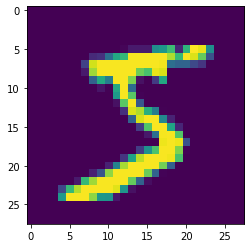

In [128]:
plt.imshow(X_train[0, :,:])

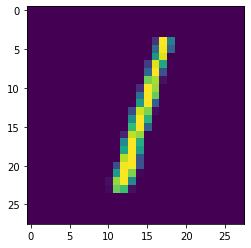

In [129]:
plt.imshow(X_test[2, :,:])

Implemente un código que visualice 8 imágenes de cada clase en una grilla de 8x10. Utiliza la función subplots de matplotlib.pyplot para generar la grilla

In [130]:
#dictionary of indexes of digits
digits = {}

for i in range(10):
    digits[i] = np.where(Y_train==i)[0][:8]

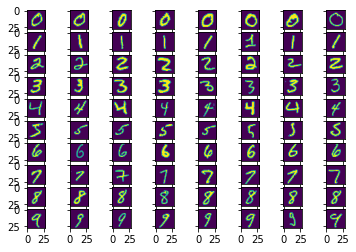

In [131]:
fig, ax = plt.subplots(10, 8, sharex='col', sharey='row')

for i in range(10):
    for j in range(8):
        ax[i, j].imshow(X_train[digits[i][j]])

# Normalización de las imágenes

Los pixeles de las imágenes están codificados en el rango 0-255. Es más beneficioso para el entrenamiento de la red que estén normalizadas, con media 0 y varianza 1. La normalización debe realizarse a nivel de pixel, es decir, se debe calcular la media de todos los pixeles de todas las imágenes, luego la varianza de todos los pixeles de todas las imágenes y luego realizar la normalización. En este caso tanto la media como la varianza son escalares, ya que cada pixel está codificado por un solo valor. Implementa dicha normalización utilizando numpy, antes de las etapas de entrenamiento y clasificación.

In [132]:
# cantidad de ejemplos y dimension de entrada
n,h,w=X_train.shape
# calcula la cantidad de clases
classes=int(Y_train.max()+1)

In [133]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [134]:
print('Mean: {} \nStd: {}'.format(X_train.mean(), X_train.std()))

Mean: -3.064638490070051e-17 
Std: 0.9999999999999998


# Aplanamiento

Para clasificar con una red neuronal con capas del tipo x*W+b (clase Dense en Keras), el formato de imagen (N,H,W) no sirve. Por ende los ejemplos deben adaptarse al formato (N,V), donde V es la cantidad de variables, que en este caso sería V=H*W=28*28= 784.  La capa Flatten realiza esta operación por nosotros:

In [135]:
model = Sequential()
#model.add(Conv2D(64, kernel_size = 3, activation='relu', input_shape=INPUT_SHAPE))
model.add(Flatten(input_shape=(28,28)))
#Nota: La API de Keras es inconsistente, y utiliza el parámetro input_shape en la clase Flatten, 
#mientras que en el resto de capas se utiliza el parámetro input_dim. Recordamos que este parámetro 
#sólo es necesario en la primera capa para especificar el tamaño de la entrada.

# Entrenamiento

Entrene un modelo para clasificar las imágenes, utilizando una softmax en la capa de salida y la entropía cruzada como función de error.  Mida el error y el accuracy en el conjunto de test (y el de train). Compute la matriz de confusión, pero antes de mirarla ¿qué pares de clases le parece que van a confundirse más?.

In [136]:
n_clases = 10

model.add(Dense(32,activation='relu'))
model.add(Dense(classes, activation='softmax'))
model.compile(
  optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,amsgrad=False), 
  loss='sparse_categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=['accuracy'], 
)

In [137]:
# Entrenamiento del modelo
model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test,Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.2724 - acc: 0.9181 - val_loss: 0.1685 - val_acc: 0.9493
Epoch 2/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.1508 - acc: 0.9548 - val_loss: 0.1508 - val_acc: 0.9555
Epoch 3/10
60000/60000 [==============================] - 6s 95us/step - loss: 0.1206 - acc: 0.9625 - val_loss: 0.1366 - val_acc: 0.9590
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1042 - acc: 0.9681 - val_loss: 0.1241 - val_acc: 0.9633
Epoch 5/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.0928 - acc: 0.9717 - val_loss: 0.1403 - val_acc: 0.9611
Epoch 6/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.0849 - acc: 0.9734 - val_loss: 0.1217 - val_acc: 0.9666
Epoch 7/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.0770 - acc: 0.9753 - val_loss: 0.1330 - val_acc

In [138]:
print(model.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_26 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [139]:
#Confution Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred,axis = 1) 

In [140]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_pred_labels))

Confusion Matrix
[[ 963    1    2    0    0    2    6    3    2    1]
 [   0 1121    3    0    0    1    2    1    7    0]
 [   4    2  998    6    6    0    5    9    2    0]
 [   2    0   10  970    1   15    0    6    6    0]
 [   0    0    0    1  964    0   10    2    2    3]
 [   6    1    2   14    1  841   12    4   10    1]
 [   8    2    0    0    5    3  937    0    3    0]
 [   2    7   12    2    1    0    0  994    4    6]
 [  10    1    6    9    4    4    5    6  929    0]
 [   4    5    2    9   36    5    1   10   20  917]]


In [141]:
print('Classification Report')
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
print(classification_report(Y_test, y_pred_labels, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       980
           2       0.98      0.99      0.99      1135
           3       0.96      0.97      0.97      1032
           4       0.96      0.96      0.96      1010
           5       0.95      0.98      0.96       982
           6       0.97      0.94      0.95       892
           7       0.96      0.98      0.97       958
           8       0.96      0.97      0.96      1028
           9       0.94      0.95      0.95       974
          10       0.99      0.91      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# CNN en MNIST

Diseñe un modelo de Redes Neuronales Convolucionales (CNN) para clasificar el conjunto de datos MNIST. Pruebe varios modelos distintos, variando los siguientes hiperparámetros (Recuerde evaluar en el conjunto de testing):<br>
●       Cantidad de capas Conv <br>
●       Cantidad de feature maps (kernels)<br>
●       Stride, padding y kernel_size de las convoluciones<br>
●       Funciones de activación<br>
●       Uso de capas Max Pooling.<br>
●       Cantidad de neuronas ocultas<br>

In [142]:
X_train.shape

(60000, 28, 28)

In [143]:
input_shape = (28, 28, 1)

In [144]:
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [145]:
# Diapositiva
model = Sequential()
model.add(Conv2D(64, kernel_size = 3, activation='relu', input_shape=(input_shape)))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

In [146]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
flatten_27 (Flatten)         (None, 43264)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                432650    
Total params: 433,290
Trainable params: 433,290
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.compile(
  optimizer=keras.optimizers.Adam(lr=0.001,beta_1=0.9,beta_2=0.999,amsgrad=False), 
  loss='sparse_categorical_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=['accuracy']
)
# Entrenamiento del modelo
model.fit(X_train, Y_train, epochs=10, batch_size=16, validation_data=(X_test,Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 55s 913us/step - loss: 0.1408 - acc: 0.9576 - val_loss: 0.0647 - val_acc: 0.9804
Epoch 2/10
60000/60000 [==============================] - 55s 921us/step - loss: 0.0558 - acc: 0.9825 - val_loss: 0.0654 - val_acc: 0.9799
Epoch 3/10
60000/60000 [==============================] - 55s 921us/step - loss: 0.0335 - acc: 0.9887 - val_loss: 0.0679 - val_acc: 0.9793
Epoch 4/10
60000/60000 [==============================] - 51s 848us/step - loss: 0.0207 - acc: 0.9933 - val_loss: 0.0697 - val_acc: 0.9810
Epoch 5/10
60000/60000 [==============================] - 51s 852us/step - loss: 0.0151 - acc: 0.9950 - val_loss: 0.0808 - val_acc: 0.9804
Epoch 6/10
60000/60000 [==============================] - 51s 856us/step - loss: 0.0098 - acc: 0.9968 - val_loss: 0.1093 - val_acc: 0.9754
Epoch 7/10
60000/60000 [==============================] - 56s 936us/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.

In [148]:
#Confution Matrix and Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred,axis = 1) 

In [149]:
print('Confusion Matrix')
print(confusion_matrix(Y_test, y_pred_labels))

Confusion Matrix
[[ 972    0    3    0    0    0    3    1    1    0]
 [   1 1126    6    0    0    0    1    1    0    0]
 [   2    0 1011    0    2    0    3   10    3    1]
 [   0    0    4  978    0   17    1    6    4    0]
 [   0    0    1    0  969    0    5    1    0    6]
 [   2    1    1    3    0  880    2    0    3    0]
 [   6    2    0    2    1    8  935    1    3    0]
 [   0    4    9    3    1    0    0 1005    3    3]
 [   5    0    2    2    2    1    0    4  955    3]
 [   3    2    2    2    6    6    0    8    1  979]]


In [150]:
print('Classification Report')
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
print(classification_report(Y_test, y_pred_labels, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       980
           2       0.99      0.99      0.99      1135
           3       0.97      0.98      0.98      1032
           4       0.99      0.97      0.98      1010
           5       0.99      0.99      0.99       982
           6       0.96      0.99      0.98       892
           7       0.98      0.98      0.98       958
           8       0.97      0.98      0.97      1028
           9       0.98      0.98      0.98       974
          10       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

